# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [142]:
import os
import cv2
from PIL import Image
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [143]:
path = '../data/images'
pixels_per_side = 220
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [144]:
print("Using device: ", device)

Using device:  cuda


## Dataset loading and preprocessing

In [145]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
labels = np.array(labels)
classes = ['Danaus plexippus', 'Heliconius charitonius', 'Heliconius erato', 'Junonia coenia', 'Lycaena phlaeas',
           'Nymphalis antiopa', 'Papilio cresphontes', 'Pieris rapae', 'Vanessa atalanta', 'Vanessa cardui']

In [146]:
print([classes[labels[i]] for i in range(10)])

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


Display some samples

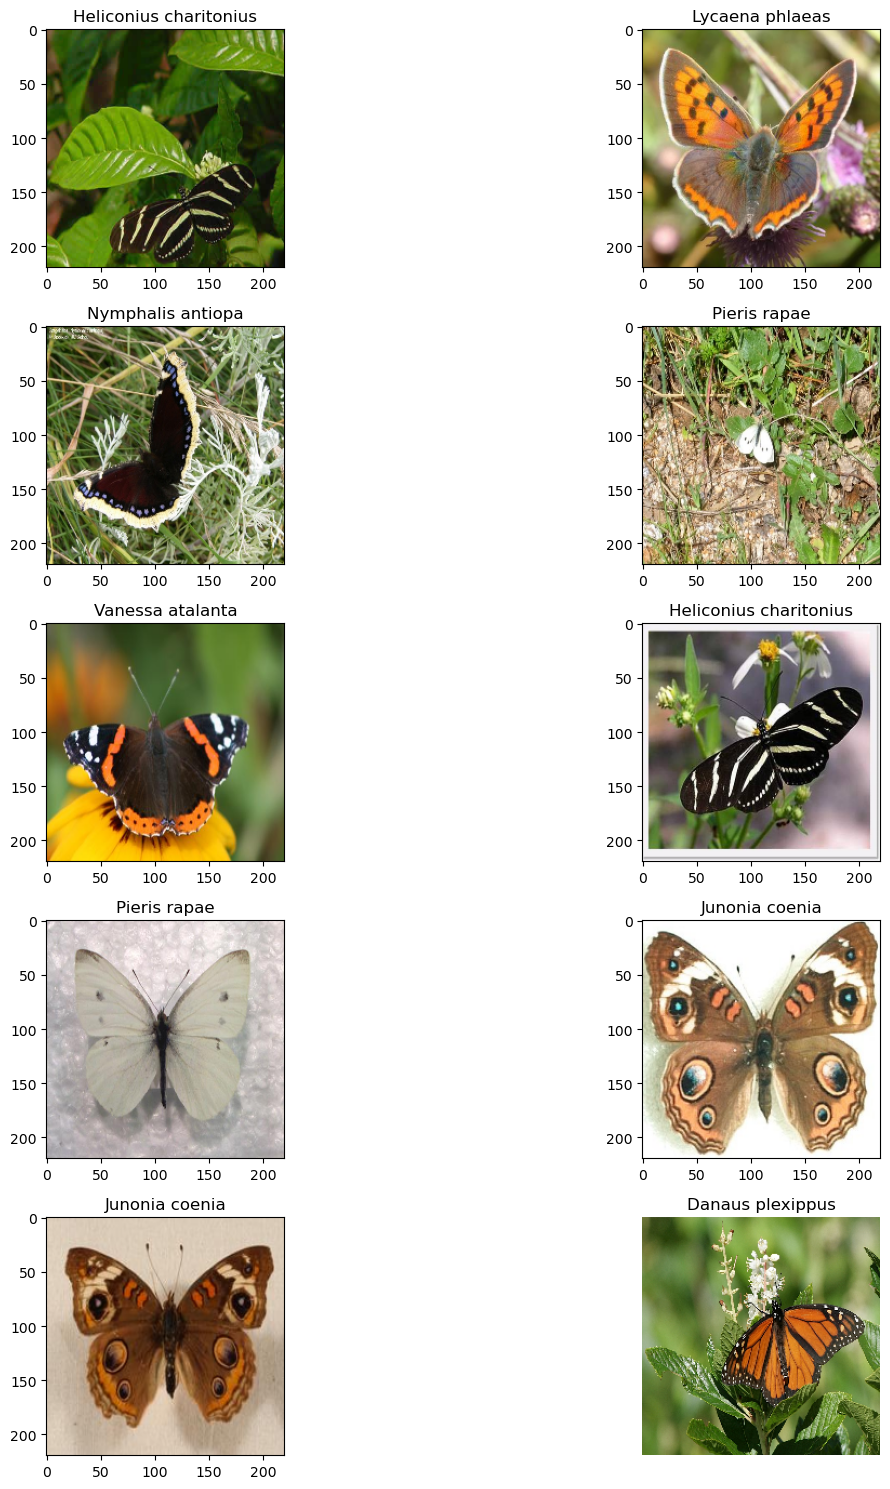

In [147]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(classes[labels[l]]))
plt.axis('off')        
plt.tight_layout()

Display dataset distribution

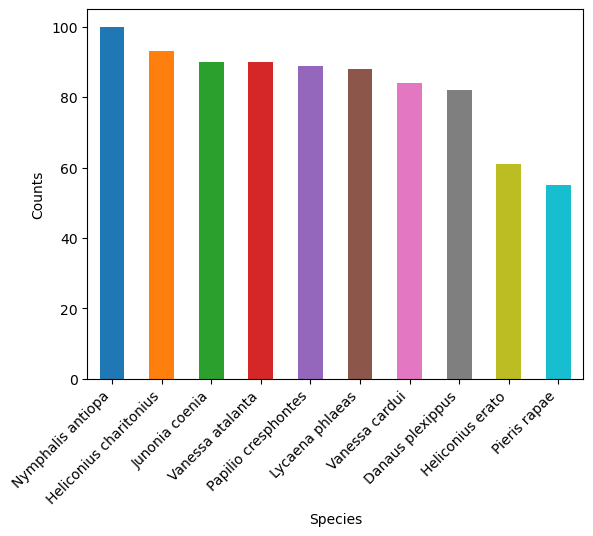

In [148]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = [classes[i] for i in df['labels']]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

In [149]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data, mode='RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx])
        return data, labels

In [150]:
trans = transforms.Compose([
    transforms.ToTensor()
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
sum_of_squared_diff = torch.zeros(3)
for images, _ in dataloader:
    sum_of_squared_diff += ((images - mean.unsqueeze(1).unsqueeze(2))**2).sum(dim=[0, 2, 3])
std = torch.sqrt(sum_of_squared_diff / total_count)
mean = [mean[0].item(), mean[1].item(), mean[2].item()]
std = [std[0].item(), std[1].item(), std[2].item()]

In [151]:
print(mean, std)

[0.461637943983078, 0.44685569405555725, 0.3207900822162628] [0.2861816883087158, 0.268231064081192, 0.27685609459877014]


Check data and labels for inspection

In [152]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)
print(data)
print(labels)

(832, 220, 220, 3) (832,)
[[[[ 56 133   1]
   [ 62 135   7]
   [ 69 139  16]
   ...
   [110 145  51]
   [126 149  73]
   [136 182 101]]

  [[ 58 134   7]
   [ 60 134   0]
   [ 65 136   6]
   ...
   [112 147  57]
   [117 144  67]
   [133 170  92]]

  [[ 62 136  25]
   [ 61 135   1]
   [ 63 135   0]
   ...
   [116 150  63]
   [109 142  63]
   [131 156  83]]

  ...

  [[116 185  48]
   [117 188  56]
   [113 189  57]
   ...
   [ 93 134  53]
   [ 85 128  58]
   [ 77 124  56]]

  [[123 193  65]
   [118 192  63]
   [115 193  54]
   ...
   [ 88 132  44]
   [ 80 127  45]
   [ 68 119  39]]

  [[119 192  61]
   [116 194  56]
   [111 193  48]
   ...
   [ 83 130  36]
   [ 74 125  30]
   [ 61 118  25]]]


 [[[ 86 114 100]
   [ 44  72  58]
   [ 48  74  61]
   ...
   [ 46  53  46]
   [ 46  53  46]
   [ 48  55  48]]

  [[ 55  83  69]
   [ 66  94  80]
   [ 60  86  73]
   ...
   [ 46  53  46]
   [ 46  53  46]
   [ 48  55  48]]

  [[ 61  89  75]
   [ 72 101  86]
   [ 54  80  67]
   ...
   [ 46  53  46]
  

## Training pipeline

Split into training data and test data

In [153]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
trainset, testset = random_split(dataset, [0.85, 0.15])

CNN definition

In [154]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120 * 48 * 48, 64) # ((220 -4)/2 -4)/2 -4
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 216, 216]          456
├─MaxPool2d: 1-2                         [1, 6, 108, 108]          --
├─Conv2d: 1-3                            [1, 16, 104, 104]         2,416
├─MaxPool2d: 1-4                         [1, 16, 52, 52]           --
├─Conv2d: 1-5                            [1, 120, 48, 48]          48,120
├─Flatten: 1-6                           [1, 276480]               --
├─Linear: 1-7                            [1, 64]                   17,694,784
├─Linear: 1-8                            [1, 10]                   650
Total params: 17,746,426
Trainable params: 17,746,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 175.97
Input size (MB): 0.58
Forward/backward pass size (MB): 5.84
Params size (MB): 70.99
Estimated Total Size (MB): 77.40

Train and validate methods

In [155]:
def fit(net, trainloader, optimizer, loss_fn=nn.CrossEntropyLoss()):
    net.train()
    total_loss = acc = count = 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

def predict(net, valloader, loss_fn=nn.CrossEntropyLoss()):
    net.eval()
    count = acc = total_loss = 0
    with torch.no_grad():
        for features, labels in valloader:
            features = features.to(device)
            labels = labels.to(device)
            count += len(labels)
            out = net(features)
            total_loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum()
    return total_loss.item() / count, acc.item() / count

Objective method for k fold cross validation

In [163]:
def objective(trial, trainset, X, y):
    lr = trial.suggest_float('lr', 0.001, 0.1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    epochs = trial.suggest_int('epochs', 10, 30)
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    print(f"\ntrial #{trial.number+1} => lr={lr}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}")
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    val_accs = []
    split_num = 0
    for train_index, val_index in skf.split(X, y):
        split_num += 1
        train_data = Subset(trainset, train_index)
        val_data = Subset(trainset, val_index)
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train_loss, train_acc = fit(net, trainloader, optimizer)
            val_loss, val_acc = predict(net, valloader)
            
        val_accs.append(val_acc)
        mean_acc = np.mean(val_accs)
        trial.report(mean_acc, split_num)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    print(f"Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
    return mean_acc

In [166]:
X = np.zeros(len(trainset))
labelloader =  DataLoader(trainset, batch_size=128, shuffle=False)
y = []
for _, label in labelloader:
    y.append(label.numpy())
y = np.concatenate(y, axis=0)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, X, y), n_trials=6)


trial #1 => lr=0.0036881297167943024, batch_size=128, epochs=18, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0036881297167943024
    maximize: False
    weight_decay: 0
)
Train acc=1.000, Val acc=1.000, Train loss=0.000, Val loss=0.000

trial #2 => lr=0.08326229758700436, batch_size=128, epochs=22, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.08326229758700436
    maximize: False
    weight_decay: 0
)
Train acc=0.121, Val acc=0.114, Train loss=0.018, Val loss=0.033

trial #3 => lr=0.031821665784531446, batch_size=64, epochs=21, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0

In [167]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  6
  Number of pruned trials:  0
  Number of complete trials:  6
Best trial:
  Value:  0.9676056338028168
  Params: 
    lr: 0.0013624002298202847
    batch_size: 256
    epochs: 25


In [168]:
net = Net().to(device)
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 216, 216]          456
├─MaxPool2d: 1-2                         [1, 6, 108, 108]          --
├─Conv2d: 1-3                            [1, 16, 104, 104]         2,416
├─MaxPool2d: 1-4                         [1, 16, 52, 52]           --
├─Conv2d: 1-5                            [1, 120, 48, 48]          48,120
├─Flatten: 1-6                           [1, 276480]               --
├─Linear: 1-7                            [1, 64]                   17,694,784
├─Linear: 1-8                            [1, 10]                   650
Total params: 17,746,426
Trainable params: 17,746,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 175.97
Input size (MB): 0.58
Forward/backward pass size (MB): 5.84
Params size (MB): 70.99
Estimated Total Size (MB): 77.40

In [169]:
trainloader = DataLoader(trainset, batch_size=trial.params['batch_size'], shuffle=True)
testloader = DataLoader(testset, batch_size=trial.params['batch_size'], shuffle=False)
optimizer = optim.Adam(net.parameters(), lr=trial.params['lr'])
for epoch in range(trial.params['epochs']):
    train_loss, train_acc = fit(net,trainloader, optimizer)
    print(f"Epoch {epoch + 1}, Train acc={train_acc:.3f}, Train loss={train_loss:.3f}")
test_loss, test_acc = predict(net, testloader)
print(f"Test acc={test_acc:.3f}, Train loss={test_loss:.3f}")

Epoch 1, Train acc=0.168, Train loss=0.024
Epoch 2, Train acc=0.150, Train loss=0.011
Epoch 3, Train acc=0.185, Train loss=0.010
Epoch 4, Train acc=0.232, Train loss=0.009
Epoch 5, Train acc=0.280, Train loss=0.009
Epoch 6, Train acc=0.388, Train loss=0.008
Epoch 7, Train acc=0.477, Train loss=0.006
Epoch 8, Train acc=0.589, Train loss=0.005
Epoch 9, Train acc=0.653, Train loss=0.004
Epoch 10, Train acc=0.715, Train loss=0.004
Epoch 11, Train acc=0.764, Train loss=0.003
Epoch 12, Train acc=0.812, Train loss=0.002
Epoch 13, Train acc=0.856, Train loss=0.002
Epoch 14, Train acc=0.866, Train loss=0.002
Epoch 15, Train acc=0.908, Train loss=0.001
Epoch 16, Train acc=0.941, Train loss=0.001
Epoch 17, Train acc=0.960, Train loss=0.001
Epoch 18, Train acc=0.983, Train loss=0.000
Epoch 19, Train acc=0.973, Train loss=0.000
Epoch 20, Train acc=0.987, Train loss=0.000
Epoch 21, Train acc=0.999, Train loss=0.000
Epoch 22, Train acc=0.999, Train loss=0.000
Epoch 23, Train acc=0.999, Train loss=0.0